In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset
https://www.kaggle.com/datasets/alizahidraja/captcha-data


In [ ]:
# Common
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Data
from glob import glob
from tqdm import tqdm
from tensorflow import io
import tensorflow.data as tfd

# Data Visualization
from IPython.display import clear_output as cls
import matplotlib.pyplot as plt

# Model
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model

Data loading

In [ ]:
# Constants
BATCH_SIZE = 16

# Image Size
N_CHANNELS = 1
IMAGE_HEIGHT, IMAGE_WIDTH = [50, 150]

# The format in which the images are stored
IMAGE_FORMAT = ".png"

# The maximum number of characters in a label.
MAX_CHARS = 5

# Total number of training epochs
EPOCHS = 100

# Learning rate
LEARNING_RATE = 1e-3

# Specify root data paths
train_path = r"/content/drive/MyDrive/new projects ai /captcha data /data/train/"
valid_path = r"/content/drive/MyDrive/new projects ai /captcha data /data/val/"

# Random Seed
SEED = 45689
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Training Paths
all_train_paths = sorted(glob(train_path + "*" + IMAGE_FORMAT))

# Validation Paths
all_valid_paths = sorted(glob(valid_path + "*" + IMAGE_FORMAT))

In [ ]:
def extract_label(path:str) -> str:

    '''
    This function takes a single argument, which is the path of the image file, and returns the label as a string. The function works by using the
    split() method to split the path into its individual components, and then extracting the label from the resulting list. Specifically, it splits
    the path using the forward slash ('/') character as a delimiter, and then uses the second-to-last component of the resulting list as the label.

    The function assumes that the label is included in the file name and is separated from the rest of the name by a period ('.') character. It
    therefore splits the file name using the period character as a delimiter, and then uses the second-to-last component of the resulting list as
    the label.

    Argument :
        path : The path from which the label is to be extracted.

    Returns :
        label : The extracted label.
    '''
    return path.split("/")[-1].split(".")[-2]

In [ ]:
extract_label(path=all_train_paths[5])


'244e2'

In [ ]:
# All training labels
all_train_labels = list(map(extract_label, all_train_paths))

# All validation labels
all_valid_labels = list(map(extract_label, all_valid_paths))

Data preprocessing

In [ ]:
def load_image(path:str):

    '''
    The load_image function loads and processes an image from a given file path using TensorFlow functions. The function takes
    in a file path as input, reads the file using the io.read_file function, and decodes the JPEG image using tf.image.decode_jpeg.
    The image is then converted to a tensor using tf.image.convert_image_dtype, resized using tf.image.resize, transposed using
    tf.transpose, and cast to tf.float32 using tf.cast.

    The processed image is returned as output from the function, which can be used for training our text recognition model.

    Argument :
        path : The location or the file path of the image

    Return :
        image : The loaded and processed image.
    '''

    # Read file
    image = io.read_file(filename=path)

    # Decode the PNG image
    image = tf.image.decode_png(contents=image, channels=N_CHANNELS)

    # Convert image to a tensor
    image = tf.image.convert_image_dtype(image=image, dtype=tf.float32)

    # Resize the image
    image = tf.image.resize(images=image, size=(IMAGE_HEIGHT, IMAGE_WIDTH))

    # Transpose
    image = tf.transpose(image, perm=[1, 0, 2])

    # Cast
    image = tf.cast(image, tf.float32)

    return image

In [ ]:
# Get the set of all unique characters : This is our character vocabulary.
characters = sorted(list(set(char for word in all_train_labels for char in word)))

# Quick look
print(f"Characters : {set(characters)}\n")
print(f"Total Number of Unique Characters : {len(characters)}")

Characters : {'7', 'e', 'm', '2', 'n', 'w', 'b', 'y', 'x', '8', '4', 'f', '6', 'p', 'd', '3', '5', 'g', 'c'}

Total Number of Unique Characters : 19


In [ ]:
print(f"Some Images : \n\t{all_train_paths[:5]}\n")
print(f"Some Labels : {all_train_labels[:5]}\n")
max_len = max(map(len, all_train_labels))
print(f"Max Len of Label : {max_len}")

Some Images : 
	['/content/drive/MyDrive/new projects ai /captcha data /data/train/226md.png', '/content/drive/MyDrive/new projects ai /captcha data /data/train/22d5n.png', '/content/drive/MyDrive/new projects ai /captcha data /data/train/2356g.png', '/content/drive/MyDrive/new projects ai /captcha data /data/train/23mdg.png', '/content/drive/MyDrive/new projects ai /captcha data /data/train/243mm.png']

Some Labels : ['226md', '22d5n', '2356g', '23mdg', '243mm']

Max Len of Label : 5


In [ ]:
# Mapping from character to numbers
char_to_num = layers.StringLookup(
    vocabulary=characters,
    mask_token=None
)

# Reverse mapping from numbers to characters.
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
    mask_token=None
)

In [ ]:
def preprocess_labels(label:str) -> tf.Tensor:
    '''
    The preprocess_labels function is used to preprocess the image labels which are in string format.
    The labels are first divided into individual characters and then each character is encoded into
    numerical values using a predefined mapping.

    Arguments:
        label: A string containing the label for an image.

    Returns:
        label: A tensor containing the numerical representation of the label.
    '''

    # Split the string label into individual characters
    label = tf.strings.unicode_split(label, input_encoding='UTF-8')

    # Encode each character into its corresponding numerical value
    label = char_to_num(label)

    return label

In [ ]:
def load_dataset(path, label):

    # Load the image
    image = load_image(path=path)

    # Extract the label
    label = preprocess_labels(label=label)

    # return the image and label
    return {"image":image, "label":label}

In [ ]:
# Trainng dataset
train_ds = tfd.Dataset.from_tensor_slices((
    np.array(all_train_paths), np.array(all_train_labels)
)).shuffle(1000).repeat(2).map(load_dataset, num_parallel_calls=tfd.AUTOTUNE).batch(BATCH_SIZE).prefetch(tfd.AUTOTUNE)

# Validation dataset
valid_ds = tfd.Dataset.from_tensor_slices((
    np.array(all_valid_paths), np.array(all_valid_labels)
)).map(load_dataset, num_parallel_calls=tfd.AUTOTUNE).batch(BATCH_SIZE).prefetch(tfd.AUTOTUNE)

Data Visualization

In [ ]:
def decode_label(label):

    '''
    This function will map the label from numbers to characters, and then join them to create the final label.

    Argument :
        label : The label to be decoded

    Return :
        label : The decoded label
    '''

    # Reverse Mapping
    label = num_to_char(label)

    # Join the chars
    label = tf.strings.reduce_join(label).numpy().decode('utf8')

    return label

In [ ]:
def data_visualization(data, model=None, decode_fn=None, GRID=[4, 4], FIGSIZE=(20,8), cmap="binary"):

    '''

    This function plots a sub plot of all the images with respect to their labels, and also decode the models predictions if the model and the decode function is supplied.

    Arguments :
        data      : The data set, which contains the images and the respective labels.
        model     : A model that will make predictions on the data.
        decode_fn : A function to decode the model predictions.
        GRID      : The 2D structure of the plots i.e. the number of rows and the number of columns.
        FIGSIZE   : The size of the plot.

    '''

    # Specify the plotting configurations
    n_rows, n_cols = GRID
    plt.figure(figsize=FIGSIZE)

    # Get the images and labels from the data
    data = next(iter(data))
    images, labels = data['image'], data['label']

    if model is not None:
        pred_labels = decode_fn(model.predict(images))

    # Iterate over the data
    for image_number, (image, label) in enumerate(zip(images, labels)):

        if model is not None:
            title = f"True : {decode_label(label)}\nPred : {pred_labels[image_number]}"
        else:
            title = decode_label(label)

        plt.subplot(n_rows, n_cols, image_number+1)
        plt.imshow(tf.transpose(tf.squeeze(image)), cmap=cmap)
        plt.axis('off')
        plt.title(title)

    # Show Plot
    cls()
    plt.show()

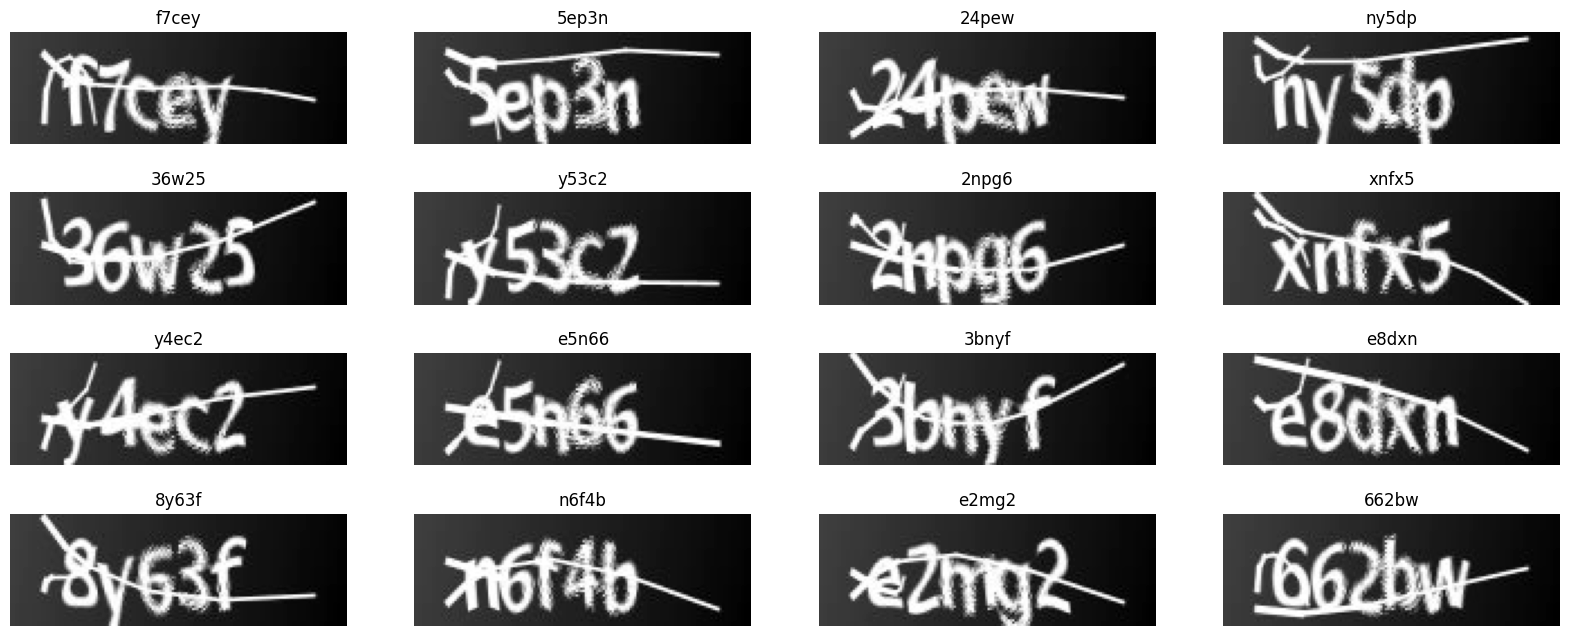

In [ ]:
data_visualization(data=train_ds)

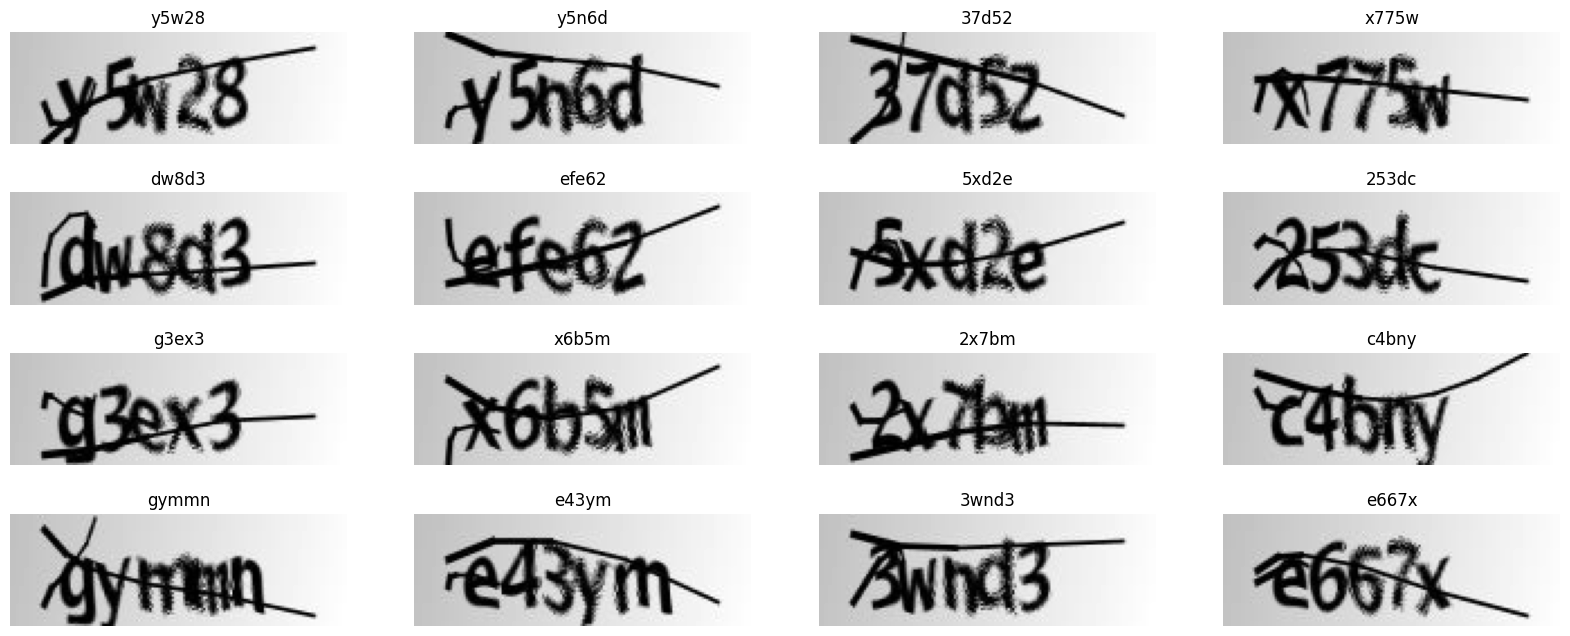

In [ ]:
data_visualization(data=train_ds, cmap='gray')


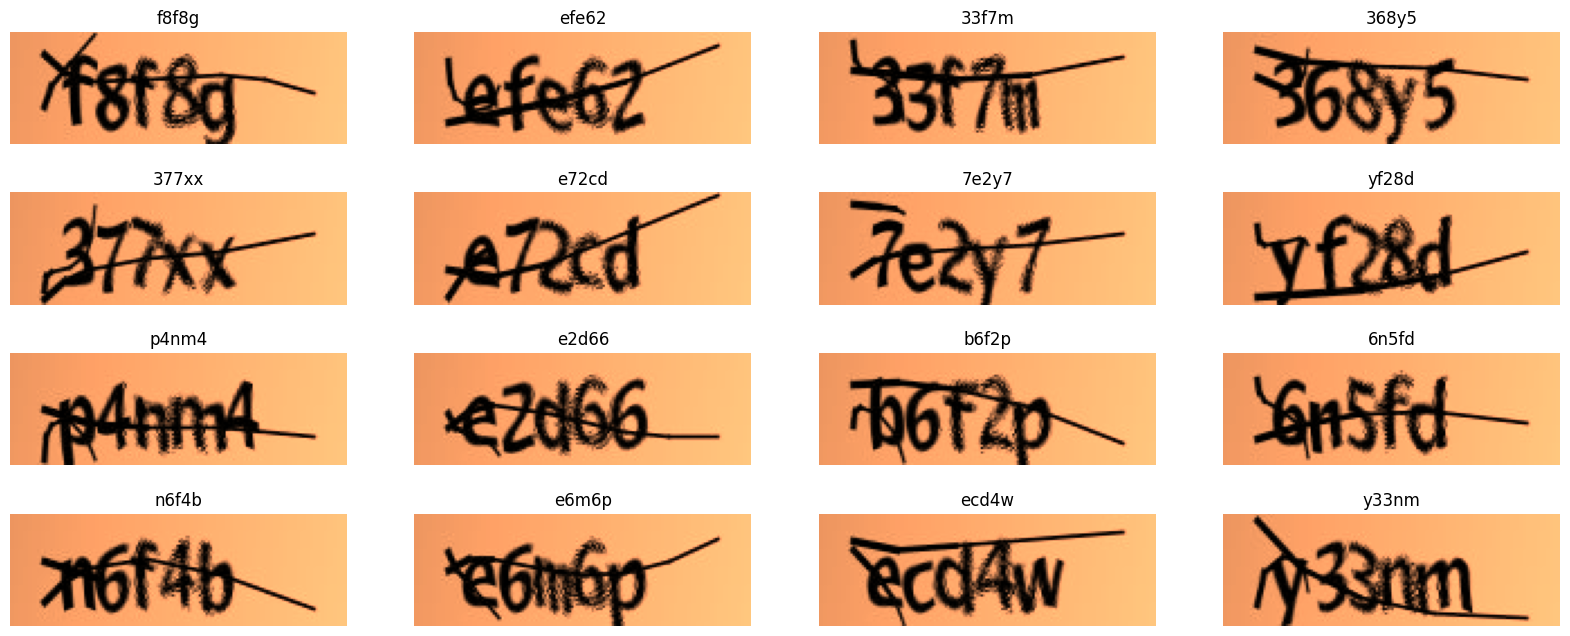

In [ ]:
data_visualization(data=train_ds, cmap='copper')


CTC Layer

In [ ]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_size = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_len  = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_len  = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_len *= tf.ones(shape=(batch_size, 1), dtype='int64')
        label_len *= tf.ones(shape=(batch_size, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        self.add_loss(loss)

        return y_pred

ocr model

In [ ]:
# Image input layer
input_image = layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, N_CHANNELS), name="image", dtype=tf.float32)

# Label input layer
input_label = layers.Input(shape=(None, ), dtype=tf.float32, name="label")

# Convolutional network part for capturing the image features.
conv_1 = layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation='relu',
    padding='same',
    kernel_initializer='he_normal',
    name="Conv1"
)(input_image)

pool_1 = layers.MaxPool2D(pool_size=(2,2), name="Pool1")(conv_1)

conv_2 = layers.Conv2D(
    filters=64,
    kernel_size=3,
    activation='relu',
    padding='same',
    kernel_initializer='he_normal',
    name="Conv2"
)(pool_1)

image_embedding = layers.MaxPool2D(pool_size=(2,2), name="Pool2")(conv_2)

# Reshaped inputs carefully for making it compatible for the recurrent neural network.
reshaped = layers.Reshape(target_shape=(IMAGE_WIDTH//4, (IMAGE_HEIGHT//4)*64), name="Reshape")(image_embedding)
encoding = layers.Dense(
    64,
    activation='relu',
    kernel_initializer='he_normal',
    name="DenseMapping"
)(reshaped)
encoding = layers.Dropout(0.2, name="DenseDrop")(encoding)

# Pass these representations to a recurrent neural network
rnn_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(encoding)
text_embedding = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(rnn_1)

# Output layer for model predictions
output_preds = layers.Dense(units=len(char_to_num.get_vocabulary())+1, activation='softmax', name="Output")(text_embedding)

# CTC loss layer
Output = CTCLayer(name="CTCLoss")(input_label, output_preds)

In [ ]:
# Final model
ocr_model = keras.Model(
    inputs=[input_image, input_label],
    outputs=[Output]
)

# Model summary
ocr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 150, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 Pool1 (MaxPooling2D)           (None, 75, 25, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 75, 25, 64)   18496       ['Pool1[0][0]']              

Model visualization

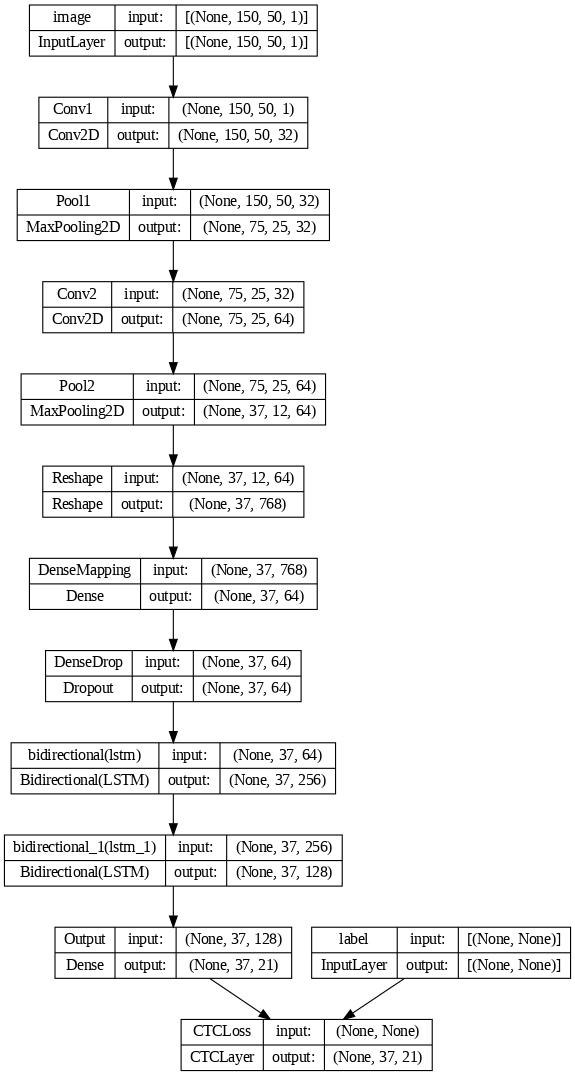

In [ ]:
plot_model(model=ocr_model, to_file="OCRCaptchModel.png", show_layer_names=True, show_shapes=True, dpi=80)

OCR Model Training


In [ ]:
# Compile the model
ocr_model.compile(optimizer=keras.optimizers.Adam())

# Model training
ocr_model_history = ocr_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=[
        #callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        callbacks.ModelCheckpoint("OCRCaptchModel.h5", save_best_only=True),
    ]
)

Epoch 1/100
104/104 [==============================] - 78s 640ms/step - loss: 18.2780 - val_loss: 16.3087
Epoch 2/100
104/104 [==============================] - 42s 400ms/step - loss: 16.3227 - val_loss: 16.3280
Epoch 3/100
104/104 [==============================] - 42s 408ms/step - loss: 16.3091 - val_loss: 16.3369
Epoch 4/100
104/104 [==============================] - 40s 388ms/step - loss: 16.2974 - val_loss: 16.3259
Epoch 5/100
104/104 [==============================] - 40s 378ms/step - loss: 16.2851 - val_loss: 16.2803
Epoch 6/100
104/104 [==============================] - 41s 390ms/step - loss: 16.2422 - val_loss: 16.1866
Epoch 7/100
104/104 [==============================] - 43s 416ms/step - loss: 16.1020 - val_loss: 15.9119
Epoch 8/100
104/104 [==============================] - 42s 402ms/step - loss: 15.8430 - val_loss: 15.7285
Epoch 9/100
104/104 [==============================] - 42s 403ms/step - loss: 15.5149 - val_loss: 15.4132
Epoch 10/100
104/104 [========================

In [ ]:
# We need a different model for making predictions
ocr_pred_model = keras.Model(
    inputs=ocr_model.get_layer("image").input,
    outputs=ocr_model.get_layer('Output').output
)

# Model Summary
ocr_pred_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 150, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 150, 50, 32)       320       
                                                                 
 Pool1 (MaxPooling2D)        (None, 75, 25, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 75, 25, 64)        18496     
                                                                 
 Pool2 (MaxPooling2D)        (None, 37, 12, 64)        0         
                                                                 
 Reshape (Reshape)           (None, 37, 768)           0         
                                                                 
 DenseMapping (Dense)        (None, 37, 64)            4921

Test model

In [ ]:
def decode_pred(pred_label):

    '''
    The decode_pred function is used to decode the predicted labels generated by the OCR model.
    It takes a matrix of predicted labels as input, where each time step represents the probability
    for each character. The function uses CTC decoding to decode the numeric labels back into their
    character values. The function also removes any unknown tokens and returns the decoded texts as a
    list of strings. The function utilizes the num_to_char function to map numeric values back to their
    corresponding characters. Overall, the function is an essential step in the OCR process, as it allows
    us to obtain the final text output from the model's predictions.

    Argument :
        pred_label : These are the model predictions which are needed to be decoded.

    Return:
        filtered_text : This is the list of all the decoded and processed predictions.

    '''

    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_CHARS]

    # Converting numerics back to their character values
    chars = num_to_char(decode)

    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

In [ ]:
# Get some data
data = next(iter(valid_ds))
images = data['image']
labels = data['label']

# Make Prediction
model_pred = ocr_pred_model.predict(tf.expand_dims(images[0], axis=0))

# Decode the model prediction.
print(f"Predicted Label : {decode_pred(model_pred)[0]}")

1/1 [==============================] - 2s 2s/step
Predicted Label : 23m8


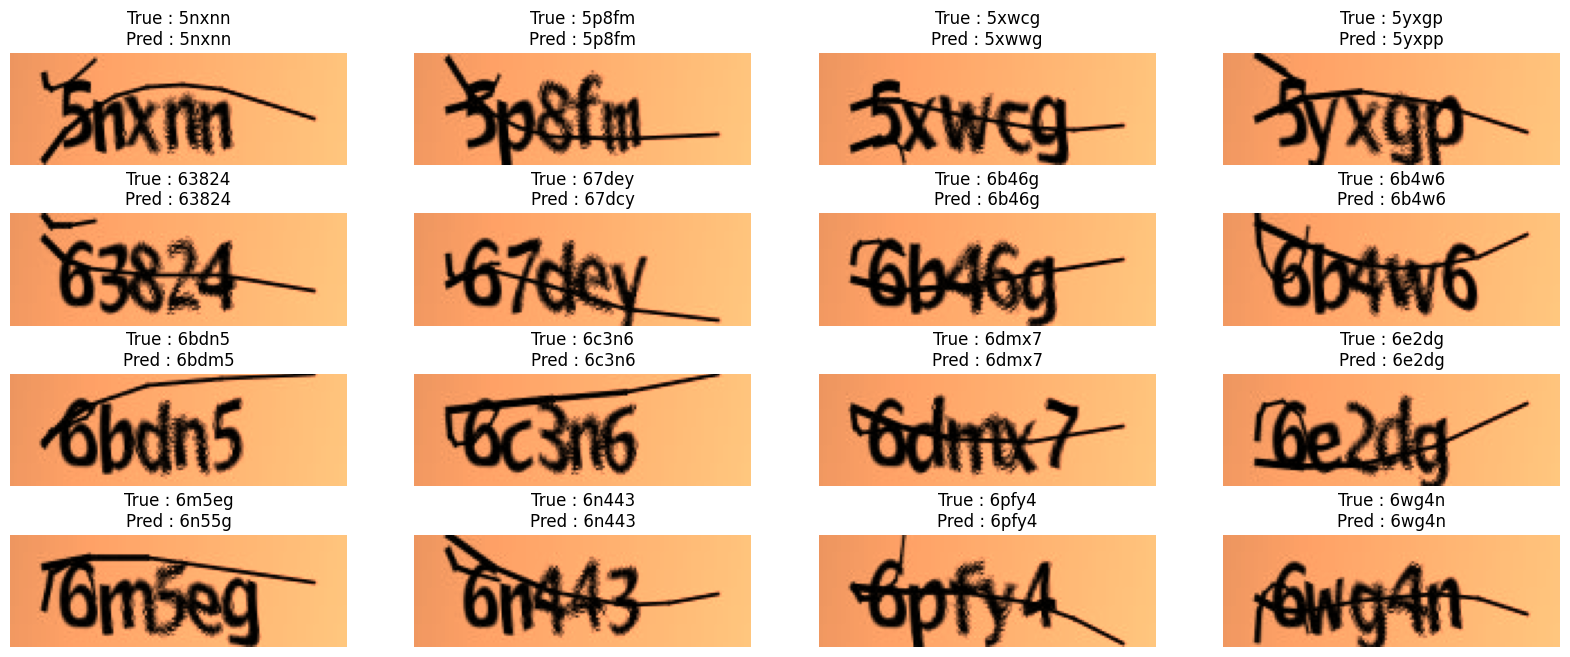

In [ ]:
data_visualization(
    data=valid_ds.shuffle(1000),
    model=ocr_pred_model,
    decode_fn=decode_pred,
    cmap='copper'
)

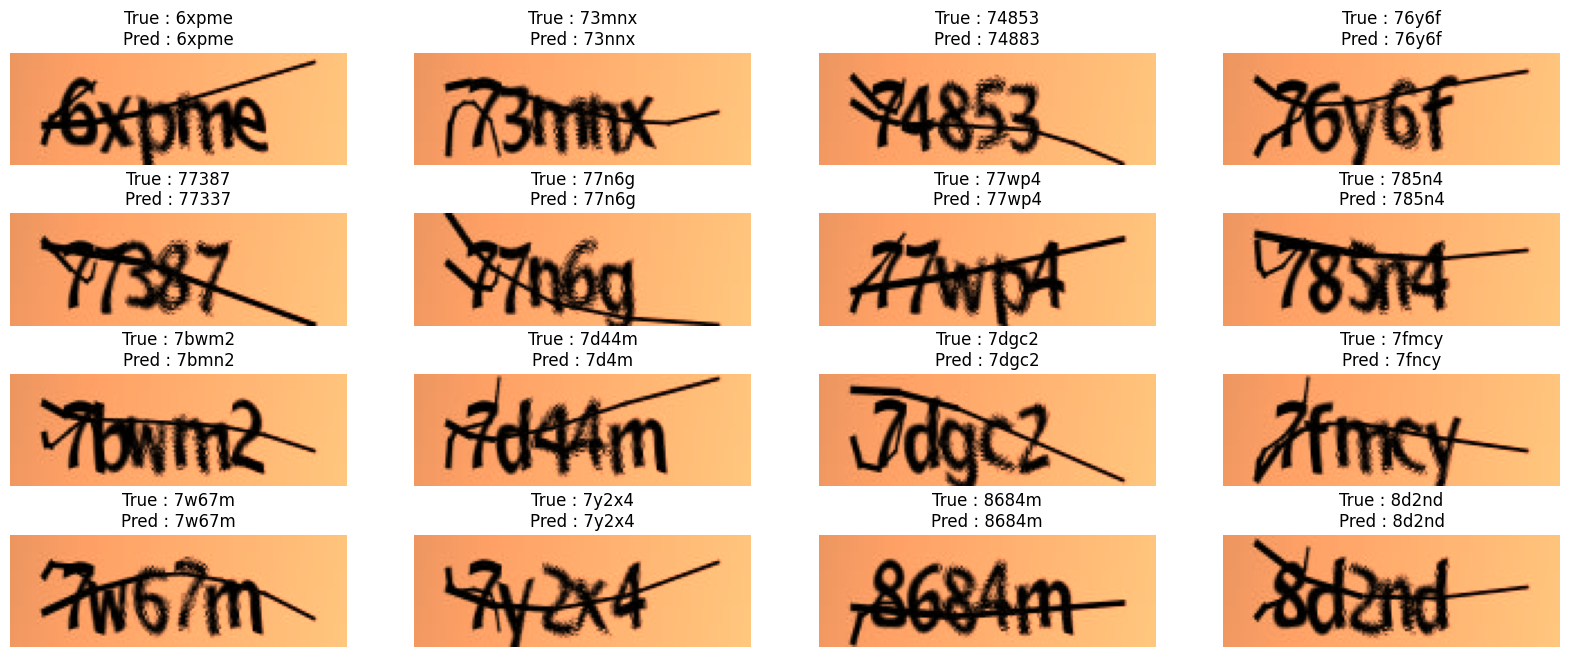

In [ ]:
data_visualization(
    data=valid_ds.shuffle(1000),
    model=ocr_pred_model,
    decode_fn=decode_pred,
    cmap='copper'
)